# Project for «Wikishop»

The online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. The store needs a tool that will search for toxic comments and send them to moderation.
Our task is to train the model to classify comments into positive and negative. At our disposal we have a data set with markup about the toxicity of edits.
<code>The final F1 must be at least 0.75 </code>

We'll tesk the following algorythms:

- Naive Bayes
- Logistic Regression
- Catboost
- LightGBM

## Overview

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, preprocessing, feature_selection
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.CRITICAL)

from lightgbm import LGBMClassifier
import tqdm

In [3]:
cwd = os.getcwd()
cwd

'/home/user-0-1410273219/work'

In [4]:
local = '/toxic_comments.csv'
practicum = '/datasets/toxic_comments.csv'

In [6]:
try:
    df = pd.read_csv(cwd+local)
except:
    df = pd.read_csv(practicum)

In [7]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
df.duplicated().sum()

0

In [10]:
df = df.drop_duplicates()

# Preprocessing

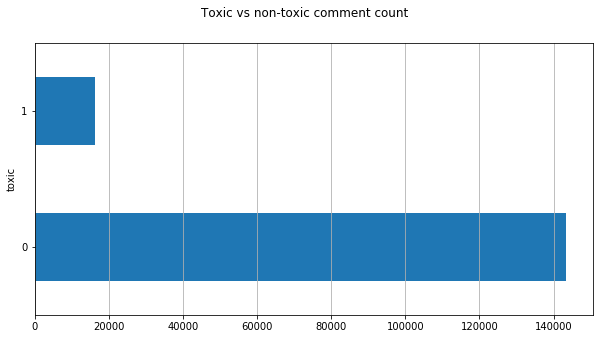

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Тoxic vs non-toxic comment count", fontsize=12)
df["toxic"].reset_index().groupby("toxic").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

There is a much smaller number of toxic comment and it's logical. Let's write a function to clean up the dataset

In [13]:
def preprocessing(text, lemm=True, stopwords=None):
    # Remove non needed symbols and lower()
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize - from string to list
    text_list = text.split()
    # Removing the stopwords
    if stopwords is not None:
        text_list = [word for word in text_list if word not in 
                    stopwords]
                
    # Lemmatization
    if  lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text_list = [lem.lemmatize(word) for word in text_list]
            
    # From list to string
    text = " ".join(text_list)
    return text

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
df['text'] = df['text'].apply(lambda x: 
          preprocessing(x, lemm=True, 
          stopwords=stopwords))
df.head()

,text,toxic
0,explanation edits made username hardcore metal...,0
1,daww match background colour im seemingly stuc...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestion improvement wondered...,0
4,sir hero chance remember page thats,0


Let's split our data in `train` & `test` 

In [16]:
train, test = model_selection.train_test_split(df, test_size=0.2)
y_train = train['toxic']
y_test = test['toxic']

In [17]:
test = test.drop('toxic', axis=1)

# Bag-of-Words

In [18]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

Let's make a dictionary of 10 000 words

In [21]:
corpus = train['text']
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

We have a lot of words in the dictionary. It can be shortened by leaving only those words that have the most effect on the toxic/non-toxic separation. To do such filtering we'll use the chi-square criterion with the help of which we will check how independent is the distribution of toxics/non-toxics from each individual word

In [22]:
y = train['toxic']
feature_names = vectorizer.get_feature_names()
p_value_limit = 0.95
features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    features = features.append(pd.DataFrame(
                   {"feature":feature_names, "score":1-p, "y":cat}))
    features = features.sort_values(["y","score"], 
                    ascending=[True,False])
    features = features[features["score"] > p_value_limit]
feature_names = features["feature"].unique().tolist()

In [23]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=feature_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [24]:
len(dic_vocabulary)

1951

We just shortened the dict from 10000 tо 1945

In [26]:
def eval_model(classifier, model_name):
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
    model["classifier"].fit(X_train, y_train)

    X_test = test["text"].values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    accuracy = metrics.accuracy_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)
    

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob[:,1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(7)
    fig.set_figwidth(16)
    fig.suptitle(f'Results for {model_name}', fontsize=16)
    
    ax[0].plot(fpr, tpr, lw=3, color='orange')
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel='True Positive Rate (Recall)', 
              title=f"ROC curve")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)


    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test, predicted_prob[:,1])
    ax[1].plot(recall, precision, lw=3)
                  
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    print("Precision:",  round(accuracy,2))
    print('F1:', round(f1, 2))


# Naive Bayes

In [27]:
classifier1 = naive_bayes.MultinomialNB()

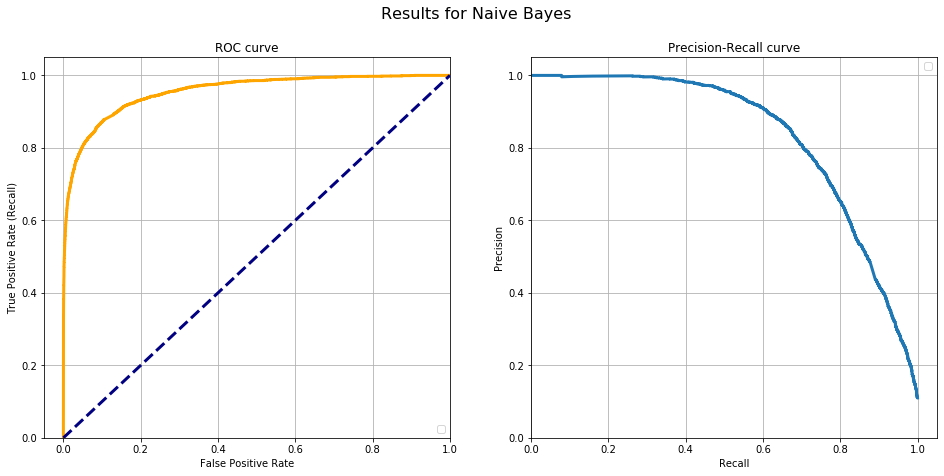

Precision: 0.95
F1: 0.72


In [28]:
eval_model(classifier1, 'Naive Bayes');

# Catboost

In [29]:
classifier2 = CatBoostClassifier(
    iterations=1000,
    eval_metric='F1',
    silent=True
)

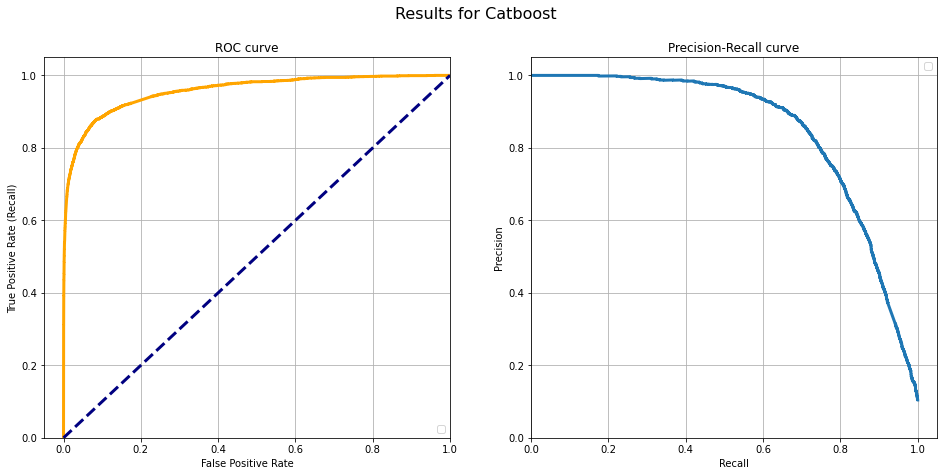

Precision: 0.96
F1: 0.76


In [24]:
eval_model(classifier2, 'Catboost')

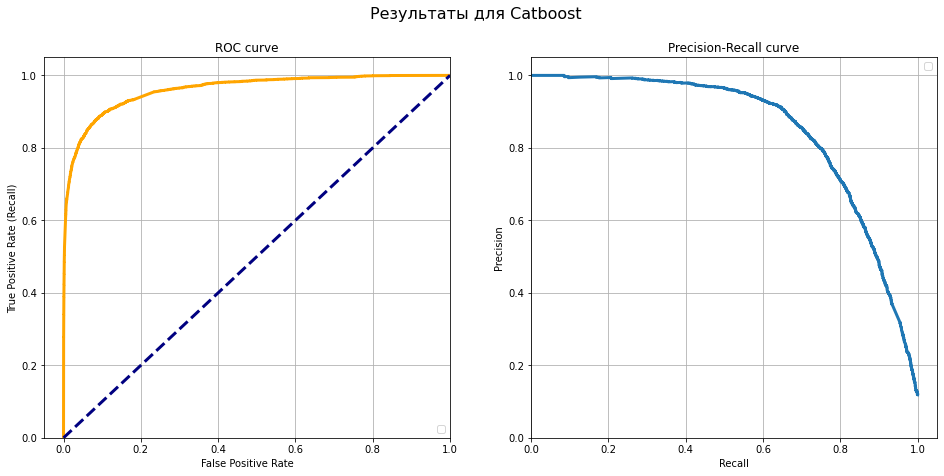

Точность: 0.95
F1: 0.76


In [247]:
eval_model(classifier2, 'Catboost')

# LogisticRegression

In [ ]:
classifier3 = LogisticRegression(
    random_state=1,
    solver='sag',
    intercept_scaling=1.5,
    C=1.5
    )

In [ ]:
lr_params = {
    'solver': ['liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l2', 'elasticnet'],
    'C':[1.0, 0.1, 0.01]
            }

In [ ]:
grid = GridSearchCV(classifier3, param_grid=lr_params, cv=3, scoring='f1')

In [ ]:
grid.fit(X_train, y_train)

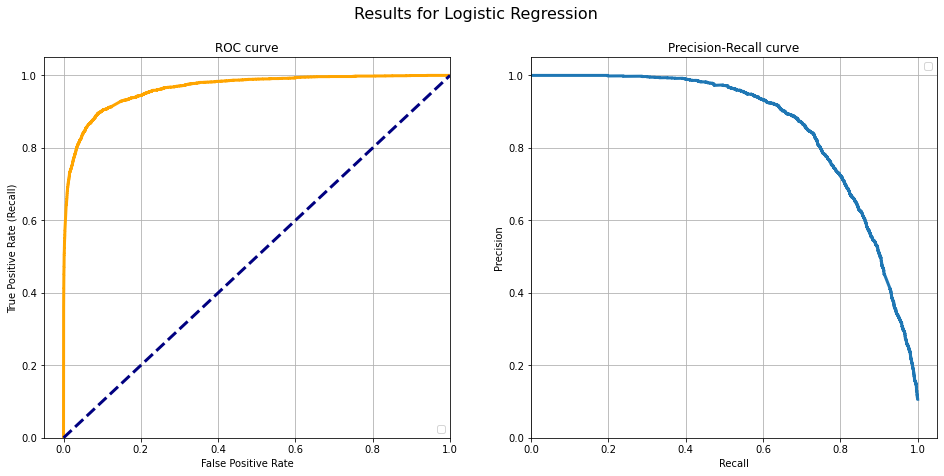

Precision: 0.96
F1: 0.76


In [26]:
eval_model(classifier3, 'Logistic Regression')

# LGBM

In [ ]:
classifier4 = LGBMClassifier(
    max_depth=50,
    num_leaves=150
)

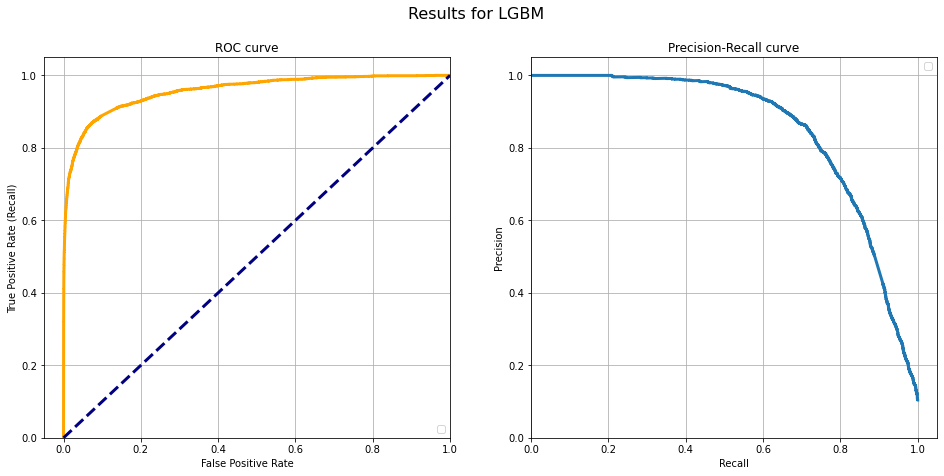

Precision: 0.96
F1: 0.76


In [28]:
eval_model(classifier4, 'LGBM')

In [ ]:
classifier5 = DummyClassifier(strategy='constant',constant=1)

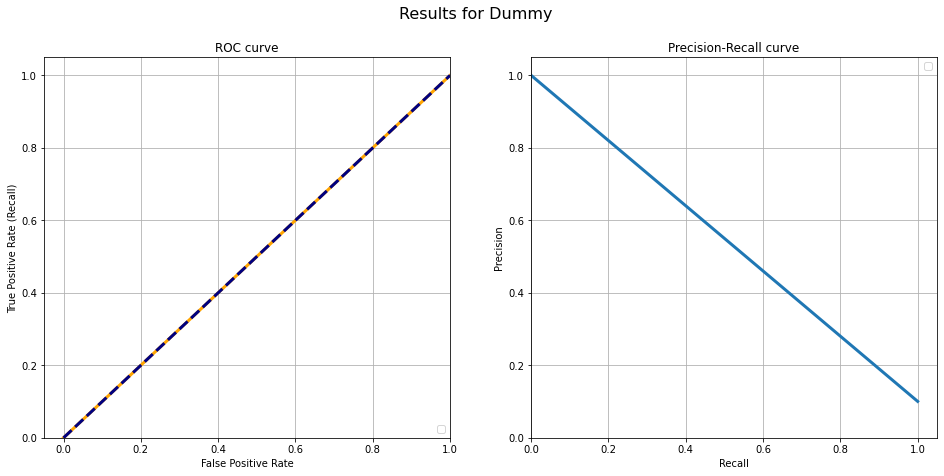

Precision: 0.1
F1: 0.18


In [30]:
eval_model(classifier5, 'Dummy')

In [ ]:
eval_model(classifier5, 'Dummy')

# Conclusion

In this situation, the <code> Logistic regression </code> with the result <code> F1 = 0.78 </code > proved to be the best. Graphs and numbers show that the <code> accuracy </code> of the models is quite high but recall is low. This means that when the model classifies a comment as toxic it has a very good chance to be toxic, but many toxic comments remain unnoticed by the model. 